In [166]:
from statlib.rand.basic_rand import BasicRand, Discrete
from statlib.rand.engine import LCG
from matplotlib import pyplot as plt
import math
import numpy as np
from scipy.stats import chi2

plt.style.use('ggplot')

In [167]:
def expectation(z):
    return sum(z) / len(z)

def dispersion(z):
    mx = expectation(z)
    return sum((z - mx) ** 2) / (len(z) - 1)

def build_sample(n, gen):
    res = []
    for i in range(n):
        res.append(gen.next())

    return np.array(sorted(res))

def get_bins_count(n):
    if n <= 100: return int(np.sqrt(n))
    return 4 * int(np.log(n))

In [168]:
_lambda = 2
n = 10000
segments = get_bins_count(n)

In [169]:
def poisson(_lambda, k):
    res = []
    for i in range(k):
        res.append((i, math.exp(-_lambda) * _lambda**i / math.factorial(i)))
    return res

In [170]:
possibilities = poisson(_lambda, 10)

gen = BasicRand(LCG())
disc_gen = Discrete(possibilities, gen)

In [171]:
x_var = build_sample(n, disc_gen)

### Равноинтервальная гистограмма

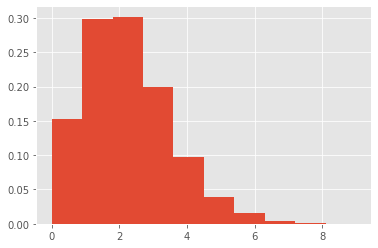

In [172]:
vals, bins, _ = plt.hist(x_var, density=True)

### Найдем точечное значение матожидания случайной величины

In [173]:
m_p = np.sum(x_var) / n
print(m_p)

2.0004


### Найдем точечное значение дисперсии случайной величины

In [174]:
d_p = np.sum((x_var - m_p)**2) / (n - 1)
print(d_p)

2.0366035003500356


### Довериетельный интервал для матожидания

In [175]:
import scipy.stats

laplace = [(x, scipy.stats.norm.cdf(x) - 0.5) for x in np.arange(0, 5, 0.01)]

def find_x_laplace(u):
    good_x = 0
    min_d = 10
    for x, y in laplace:
        if abs(u - y) < min_d:
            min_d = abs(u - y)
            good_x = x
    return good_x

def get_interval(s, val, n):
    return s * find_x_laplace(val) / np.sqrt(n)

In [176]:
alpha_e = 0.05
laplace_e = (1 - alpha_e)

interval_len = get_interval(np.sqrt(d_p), laplace_e, n)

print('Interval for E(x) with alpha = {} is ({}, {})'.format(alpha_e, m_p - interval_len, m_p + interval_len))

Interval for E(x) with alpha = 0.05 is (1.9291879007337476, 2.0716120992662526)


### Довериетельный интервал для дисперсии

In [177]:
def get_dispersion_intervals(s, alpha, n):
    l = s * (n - 1) / chi2.ppf(1 - alpha / 2, n - 1)
    r = s * (n - 1) / chi2.ppf(alpha / 2, n - 1)
    return l, r

def get_dispersion_intervals_known(s, alpha, n):
    l = s * n / chi2.ppf(1 - alpha / 2, n)
    r = s * n / chi2.ppf(alpha / 2, n)
    return l, r 

def get_dispersion_interval(x_var, alpha):
    m_p = expectation(x_var)
    d_p = dispersion(x_var)
    
    return get_dispersion_intervals(d_p, alpha, n)

In [178]:
print(d_p)
print(get_dispersion_interval(x_var, 0.05))

2.0366035003500356
(1.9813083101973363, 2.0942574212895773)


### Проверим критерий согласия Пиррсона

In [181]:
def get_F(lambda_):
    def F(x):
        x = int(x)
        return math.exp(-_lambda) * _lambda**x / math.factorial(x)
    
    return F

def pearson_chi(x_var, F, n):
    chi = 0
    for x, pi_s in possibilities:
        pi = list(x_var).count(x) / n
        chi += (pi - pi_s)**2 / pi_s
    
    return chi * n

In [182]:
chi_sqr = pearson_chi(x_var, get_F(_lambda), n)
table_pearson = chi2.ppf(0.05, segments - 1)

print('Experimental chi square: {cs}, Table chi square: {ts}'.format(cs=chi_sqr, ts=table_pearson))

if chi_sqr < table_pearson:
    print('Good')

Experimental chi square: 11.703631857626284, Table chi square: 22.465015220882684
Good
